In [1]:
import sys
import os 

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model

import pickle
import umap
import numpy as np
import matplotlib.pyplot as plt
import torch
from data_class import SongDataSet_Image
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.colors as mcolors
from hmmlearn import hmm
import colorcet as cc
import glasbey

def load_data( data_dir, context=1000, psuedo_labels_generated=True):
    dataset = SongDataSet_Image(data_dir, num_classes=196, remove_silences=False, psuedo_labels_generated=psuedo_labels_generated)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=16)
    return loader 

def generate_hdbscan_labels(array, min_samples=5, min_cluster_size=3000):
    """
    Generate labels for data points using the HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) clustering algorithm.

    Parameters:
    - array: ndarray of shape (n_samples, n_features)
      The input data to cluster.

    - min_samples: int, default=5
      The number of samples in a neighborhood for a point to be considered as a core point.

    - min_cluster_size: int, default=5
      The minimum number of points required to form a cluster.

    Returns:
    - labels: ndarray of shape (n_samples)
      Cluster labels for each point in the dataset. Noisy samples are given the label -1.
    """

    import hdbscan

    # Create an HDBSCAN object with the specified parameters.
    hdbscan_model = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)

    # Fit the model to the data and extract the labels.
    labels = hdbscan_model.fit_predict(array)

    print(np.unique(labels))

    return labels

def syllable_to_phrase_labels(arr, silence=-1):
    new_arr = np.array(arr, dtype=int)
    current_syllable = None
    start_of_phrase_index = None
    first_non_silence_label = None  # To track the first non-silence syllable

    for i, value in enumerate(new_arr):
        if value != silence and value != current_syllable:
            if start_of_phrase_index is not None:
                new_arr[start_of_phrase_index:i] = current_syllable
            current_syllable = value
            start_of_phrase_index = i
            
            if first_non_silence_label is None:  # Found the first non-silence label
                first_non_silence_label = value

    if start_of_phrase_index is not None:
        new_arr[start_of_phrase_index:] = current_syllable

    # Replace the initial silence with the first non-silence syllable label
    if new_arr[0] == silence and first_non_silence_label is not None:
        for i in range(len(new_arr)):
            if new_arr[i] != silence:
                break
            new_arr[i] = first_non_silence_label

    return new_arr

def reduce_phrases(arr, remove_silence=True):
    current_element = arr[0]
    reduced_list = [] 

    for i, value in enumerate(arr):
        if value != current_element:
            reduced_list.append(current_element)
            current_element = value 

        # append last phrase
        if i == len(arr) - 1:
            reduced_list.append(current_element)

    if remove_silence == True:
        reduced_list = [value for value in reduced_list if value != 0]

    return np.array(reduced_list)

def plot_umap_projection(model, device, data_dir="test_llb16",
                         remove_silences=False, samples=100, file_path='category_colors.pkl', 
                         layer_index=None, dict_key=None, time_bins_per_umap_point=100, 
                         context=1000, save_dir=None, raw_spectogram=False, save_dict_for_analysis=False, compute_svm=False, color_scheme="Syllable"):
    predictions_arr = []
    ground_truth_labels_arr = []
    spec_arr = [] 
    list_of_splitting_index = [] 

    # Reset Figure
    plt.figure(figsize=(8, 6))

    # to allow sci notation 
    samples = int(samples)
    total_samples = 0

    data_loader = load_data(data_dir=data_dir, context=context, psuedo_labels_generated=True)
    data_loader_iter = iter(data_loader)

    while len(ground_truth_labels_arr) * context < samples:
        try:
            # Retrieve the next batch
            data, _, ground_truth_label = next(data_loader_iter)

            # if smaller than context window, go to next song
            if data.shape[1] < context:
                continue 
            # because network is made to work with batched data, we unsqueeze a dim and transpose the last two dims (usually handled by collate fn)
            data = data.unsqueeze(0).permute(0, 1, 3, 2)

            # calculate the number of times a song 
            num_times = data.shape[-1] // context
            
            # removing left over timebins that do not fit in context window 
            shave_index = num_times * context
            data = data[:,:,:,:shave_index]

            batch, channel, freq, time_bins = data.shape 

            # cheeky reshaping operation to reshape the length of the song that is larger than the context window into multiple batches 
            data = data.permute(0,-1, 1, 2)
            data = data.reshape(num_times, context, channel, freq)
            data = data.permute(0, 2, 3, 1)

            # reshaping g truth labels to be consistent 
            batch, time_bins, labels = ground_truth_label.shape

            # shave g truth labels 
            ground_truth_label = ground_truth_label.permute(0,2,1)
            ground_truth_label = ground_truth_label[:,:,:shave_index]

            # cheeky reshaping operation to reshape the length of the song that is larger than the context window into multiple batches 
            ground_truth_label = ground_truth_label.permute(0,2,1)
            ground_truth_label = ground_truth_label.reshape(num_times, context, labels)
            
        except StopIteration:
            # if test set is exhausted, print the number of samples collected and stop the collection process
            print(f"samples collected f{len(ground_truth_labels_arr) * context}")

        if raw_spectogram == False:
            _, layers = model.inference_forward(data.to(device))

            layer_output_dict = layers[layer_index]
            output = layer_output_dict.get(dict_key, None)

            if output is None:
                print(f"Invalid key: {dict_key}. Skipping this batch.")
                continue

            batches, time_bins, features = output.shape 
            # data shape [0] is the number of batches, 
            predictions = output.reshape(batches, time_bins, features)
            # combine the batches and number of samples per context window 
            predictions = predictions.flatten(0,1)
            predictions_arr.append(predictions.detach().cpu().numpy())

        # remove channel dimension 
        data = data.squeeze(1)
        spec = data

        # set the features (freq axis to be the last dimension)
        spec = spec.permute(0, 2, 1)
        # combine batches and timebins
        spec = spec.flatten(0, 1)

        ground_truth_label = ground_truth_label.flatten(0, 1)

        ground_truth_label = torch.argmax(ground_truth_label, dim=-1)

        spec_arr.append(spec.cpu().numpy())
        ground_truth_labels_arr.append(ground_truth_label.cpu().numpy())

        list_of_splitting_index.append((spec.shape[0] + total_samples))
        
        total_samples += spec.shape[0]

    # convert the list of batch * samples * features to samples * features 
    ground_truth_labels = np.concatenate(ground_truth_labels_arr, axis=0)
    spec_arr = np.concatenate(spec_arr, axis=0)

    if not raw_spectogram:
        predictions = np.concatenate(predictions_arr, axis=0)
    else:
        predictions = spec_arr

    # Fit the UMAP reducer       
    reducer = umap.UMAP(n_neighbors=200, min_dist=0, n_components=2, metric='cosine')

    embedding_outputs = reducer.fit_transform(predictions)
    hdbscan_labels = generate_hdbscan_labels(embedding_outputs)

    list_of_phrases = []
    prev_index = 0
    for index in list_of_splitting_index:
        # print(f"prev index {prev_index}")
        # print(f"index {index}")
        list_of_phrases.append(hdbscan_labels[prev_index:index])
        prev_index = index

    for i, phrase in enumerate(list_of_phrases):
        phrase = syllable_to_phrase_labels(phrase)
        phrase = reduce_phrases(phrase, remove_silence=False)
        list_of_phrases[i] = phrase

    # print(list_of_phrases)
    import csv 
    with open("gtruth_pst_data", 'w', newline='') as file:
        writer = csv.writer(file)

        # Write each sublist to the CSV file
        for row in list_of_phrases:
            writer.writerow(row)
    
    np.savez_compressed('hdbscan_and_gtruth.npz', ground_truth_labels=ground_truth_labels, embedding_outputs=embedding_outputs, hdbscan_labels=hdbscan_labels)

    cmap = glasbey.extend_palette(["#000000"], palette_size=30)
    cmap = mcolors.ListedColormap(cmap)    

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure and a 1x2 grid of subplots

    # Scatter plot for HDBSCAN
    scatter_hdbscan = axes[0].scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], c=hdbscan_labels, s=10, alpha=.1, cmap=cmap)
    axes[0].set_title("HDBSCAN")
    
    # Create a legend for HDBSCAN
    legend1_labels = np.unique(hdbscan_labels)
    legend1_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(label)), linestyle='None', markersize=10) for label in legend1_labels]
    axes[0].legend(handles=legend1_handles, labels=legend1_labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Scatter plot for Original Coloring
    scatter_original = axes[1].scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], c=ground_truth_labels, s=10, alpha=.1, cmap=cmap)
    axes[1].set_title("Original Coloring")

    # Create a legend for Original Coloring
    legend2_labels = np.unique(ground_truth_labels)
    legend2_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(label)), linestyle='None', markersize=10) for label in legend2_labels]
    axes[1].legend(handles=legend2_handles, labels=legend2_labels, title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')


    if raw_spectogram:
        plt.title(f'UMAP of Spectogram', fontsize=14)
    else:
        plt.title(f'UMAP Projection of (Layer: {layer_index}, Key: {dict_key})', fontsize=14)

    # Save the plot if save_dir is specified
    if save_dir:
        plt.savefig(save_dir, format='png')
    else:
        plt.show()

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/george-vengrovski/anaconda3/envs/t

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("src")

from utils import load_model, detailed_count_parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# device = torch.device("cuda")

os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

# Plotting PCA, UMAP, and TweetyBERT plots of birdsong samples 

weights_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE-Mask-Before-50-mask-alpha-1/saved_weights/model_step_6400.pth"
config_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE-Mask-Before-50-mask-alpha-1/config.json"

model = load_model(config_path, weights_path)
model = model.to(device)
  
plot_umap_projection(
model=model, 
device=device, 
data_dir="/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test",
remove_silences=False,  # Using new config parameter``
samples=5e5, 
file_path="/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/category_colors_llb3.pkl", 
layer_index=1, 
dict_key="attention_output", 
time_bins_per_umap_point=1, 
context=1000,  # Using new config parameter98
raw_spectogram=False,
save_dict_for_analysis = True,
save_dir="/home/george-vengrovski/Documents/projects/tweety_bert_paper/raw_spec_phrase_labels.png",
compute_svm= False,
color_scheme = "Label"
)

: 

: 

## PST Code

In [15]:
import os

class PSTNode:
    def __init__(self, depth=0, parent=None):
        self.children = {}
        self.transitions = {}
        self.depth = depth
        self.parent = parent  # Add a parent reference

    def add_transition(self, symbol):
        if symbol in self.transitions:
            self.transitions[symbol] += 1
        else:
            self.transitions[symbol] = 1

    def calculate_probabilities(self, min_frequency=1):
        self.transitions = {symbol: count for symbol, count in self.transitions.items() if count >= min_frequency}
        total_transitions = sum(self.transitions.values())
        for symbol, count in self.transitions.items():
            self.transitions[symbol] = count / total_transitions

class ProbabilisticSuffixTree:
    def __init__(self, max_order=None, min_frequency=1):
        self.root = PSTNode()
        self.max_order = max_order
        self.min_frequency = min_frequency

    def insert_sequence(self, sequence):
        for start in range(len(sequence)):
            current_node = self.root
            for end in range(start + 1, len(sequence) + 1):
                if self.max_order is not None and end - start > self.max_order:
                    break
                symbol = sequence[end - 1]
                if symbol not in current_node.children:
                    current_node.children[symbol] = PSTNode(current_node.depth + 1, current_node)
                current_node = current_node.children[symbol]
                if end < len(sequence):
                    current_node.add_transition(sequence[end])

    def build_tree(self, sequences):
        for seq in sequences:
            self.insert_sequence(seq)

    def calculate_all_probabilities(self, node=None):
        if node is None:
            node = self.root
        node.calculate_probabilities(self.min_frequency)
        for symbol, child in list(node.children.items()):
            self.calculate_all_probabilities(child)
            # If child becomes a leaf node after pruning, remove it
            if not child.transitions:
                del node.children[symbol]
                
def read_sequences_from_file(filename):
    sequences = []
    with open(filename, 'r') as file:
        for line in file:
            sequence = line.strip().split(',')
            sequences.append(sequence)
    return sequences

# Specify the path to your file
filename = '/home/george-vengrovski/Documents/projects/tweety_bert_paper/gtruth_pst_data.txt'

# Check if the file exists
if os.path.exists(filename):
    sequences = read_sequences_from_file(filename)

    # Build and populate the PST with max_order and min_frequency
    max_order = 5  # Maximum context depth
    min_frequency = 10  # Minimum transition frequency for pruning
    pst = ProbabilisticSuffixTree(max_order=max_order, min_frequency=min_frequency)
    pst.build_tree(sequences)
    pst.calculate_all_probabilities()

    # The PST is now built based on the sequences from the file.
else:
    print(f"File {filename} not found.")


In [16]:
def find_deep_nodes(node, min_depth, current_depth=0):
    # This list will store nodes that are at least `min_depth` deep
    deep_nodes = []

    # Check if the current node's depth meets the criteria
    if current_depth >= min_depth:
        deep_nodes.append(node)

    # Recursively search through the children of the current node
    for child in node.children.values():
        deep_nodes.extend(find_deep_nodes(child, min_depth, current_depth + 1))

    return deep_nodes

# Using the function to find nodes that are at least 4 levels deep
min_depth = 4
deep_nodes = find_deep_nodes(pst.root, min_depth)

import json
from graphviz import Digraph

def visualize_subtree_with_limit(node, max_depth, graph=None, parent_id=None, edge_label='', current_depth=0):
    if graph is None:
        graph = Digraph(comment='PST Subtree Limited Depth', format='png')
        graph.attr(size='100,100')

    # Stop the recursion if the current depth exceeds the maximum depth
    if current_depth > max_depth:
        return graph

    # Set the node ID as the symbol leading to this node, or 'Root' for the root node
    node_id = edge_label if parent_id is not None else 'Root'

    # Create a label for the node, showing its depth and the number of transitions
    node_label = f'"{node_id}"\nDepth: {current_depth}\nTransitions: {len(node.transitions)}'
    
    # Add the node to the graph with its label. If node_id is not unique, append current_depth to ensure uniqueness
    unique_node_id = f'{node_id}_{current_depth}' if node_id != 'Root' else 'Root'
    graph.node(unique_node_id, label=node_label)

    # If this node is not the root, add an edge from its parent
    if parent_id is not None:
        graph.edge(parent_id, unique_node_id, label=edge_label)

    # Recursively add children
    for symbol, child in node.children.items():
        visualize_subtree_with_limit(child, max_depth, graph, unique_node_id, symbol, current_depth + 1)

    return graph

# Set the maximum depth you want to visualize
max_depth = 5

# Visualize the subtree starting from the root, up to the maximum depth
graph_limited = visualize_subtree_with_limit(pst.root, max_depth)

# Render the graph to a file
output_path_limited = graph_limited.render('pst_subtree_visualization_limited_depth_symbol_id')

print(f"Subtree visualization (up to depth {max_depth}) saved to {output_path_limited}")


Subtree visualization (up to depth 5) saved to pst_subtree_visualization_limited_depth_symbol_id.png


## Visualize  PST Digraph

In [26]:
def visualize_single_branch(node, max_depth, graph=None, parent_id=None, symbol='', current_depth=0):
    if graph is None:
        graph = Digraph(comment='PST Single Branch', format='png')
        graph.attr(size='100,100')

    if current_depth > max_depth:
        return graph

    # Generate a unique ID for the node to ensure no collisions
    node_id = f'{symbol}_{current_depth}_{id(node)}'

    # For the first node (which is effectively the root of this branch), we don't use a symbol
    node_label = symbol if current_depth > 0 else 'Branch Root'

    # Add the node to the graph
    graph.node(node_id, label=node_label)

    # If this node is not the start of the branch, add an edge from its "parent"
    if parent_id is not None:
        graph.edge(parent_id, node_id, label=symbol)

    # Recursively add children
    for child_symbol, child in node.children.items():
        visualize_single_branch(child, max_depth, graph, node_id, child_symbol, current_depth + 1)

    return graph

# Choose the branch to visualize
# For example, visualize the first branch (change 'first_child_symbol' to the specific symbol if needed)
first_child_symbol = next(iter(pst.root.children))
first_branch_root = pst.root.children[first_child_symbol]

# Visualize the chosen branch
graph_single_branch = visualize_single_branch(first_branch_root, max_depth)

# Render the graph to a file
output_path_single_branch = graph_single_branch.render('pst_single_branch_visualization')
print(f"Single branch visualization saved to {output_path_single_branch}")


Single branch visualization saved to pst_single_branch_visualization.png


## NetworkX

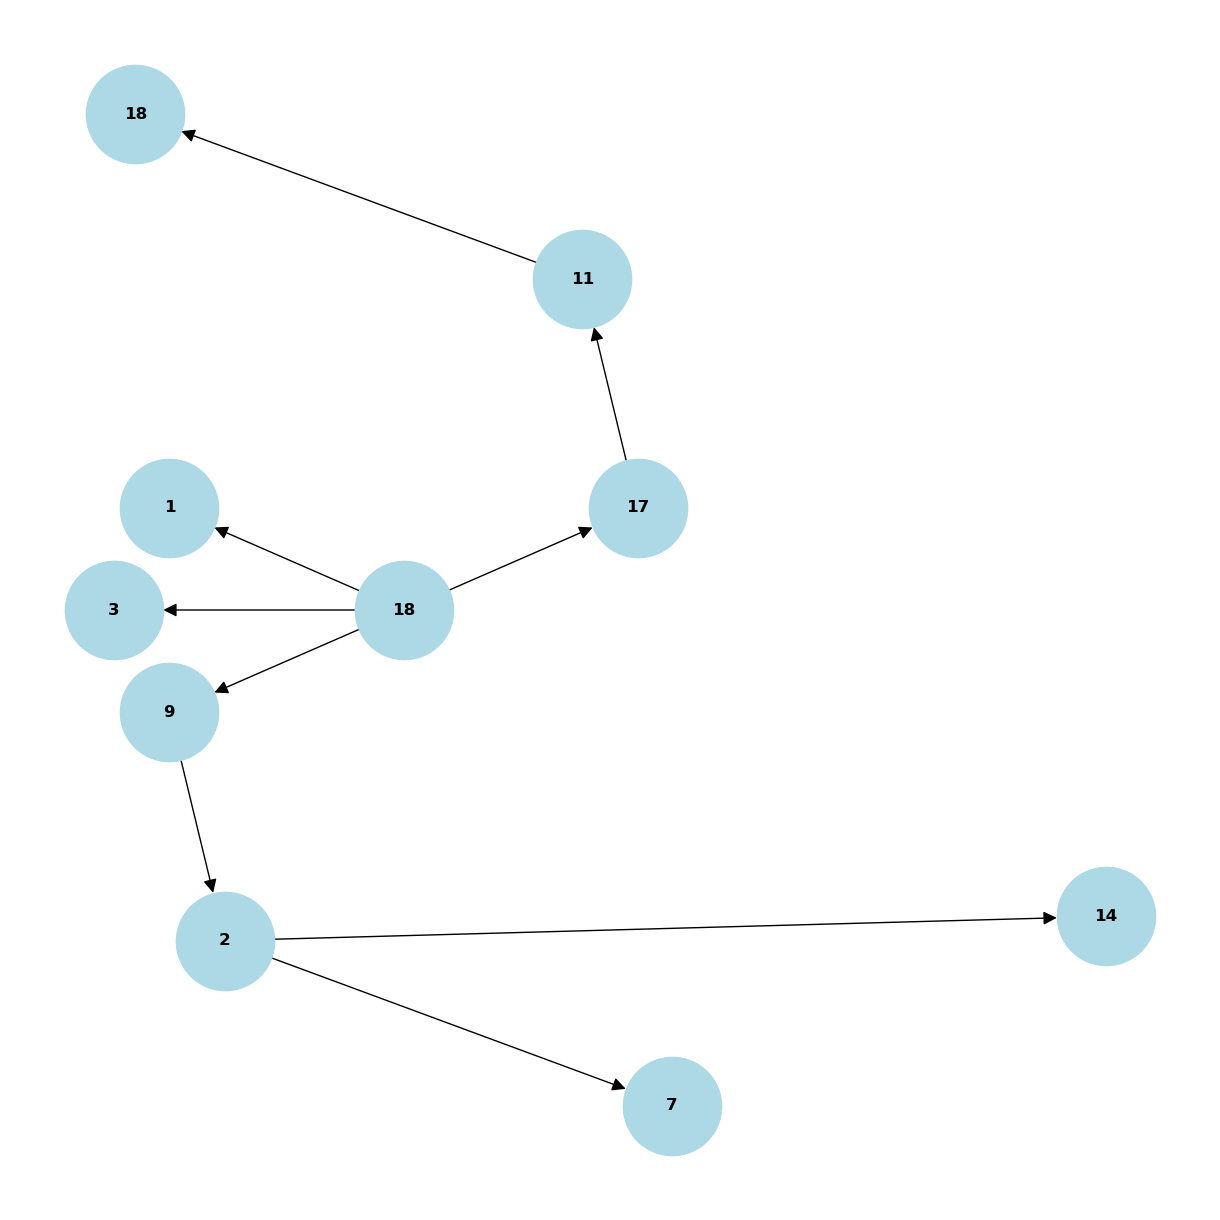

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_single_branch_networkx(node, max_depth, G=None, parent_id=None, symbol='', current_depth=0):
    if G is None:
        G = nx.DiGraph()

    if current_depth > max_depth:
        return G

    # Generate a unique ID for the node to ensure no collisions
    node_id = f'{symbol}_{current_depth}_{id(node)}'

    # For the first node (which is effectively the root of this branch), we don't add it to the graph
    if current_depth > 0:
        node_label = symbol
        G.add_node(node_id, label=node_label)

        # If this node is not the start of the branch, add an edge from its "parent"
        if parent_id is not None:
            G.add_edge(parent_id, node_id, label=symbol)

    # Recursively add children
    for child_symbol, child in node.children.items():
        # Pass the ID of the current node as the parent ID if it's not the root
        new_parent_id = node_id if current_depth > 0 else None
        visualize_single_branch_networkx(child, max_depth, G, new_parent_id, child_symbol, current_depth + 1)

    return G

def draw_networkx_graph(G, path='networkX.png'):
    # Create a position dict that will place the nodes in concentric circles
    pos = nx.circular_layout(G)  # Start with a circular layout

    # Find the root node (assuming it has no predecessors)
    root = next((node for node in G.nodes if G.in_degree(node) == 0), None)
    if root is None:
        raise ValueError("No root node found. The graph must have a root node with no incoming edges.")

    # Calculate radial positions
    radii = {0: 0}  # Root node has radius 0
    for node in G.nodes:
        if node == root:
            continue
        # Get the depth of the node (distance from the root)
        depth = nx.shortest_path_length(G, source=root, target=node)
        radii[node] = depth  # Set the radius equal to the depth

    # Maximum radius is the maximum depth of the tree
    max_radius = max(radii.values())

    # Scale positions to set each node's radius according to its depth
    for node, (x, y) in pos.items():
        if node == root:
            # Root stays at the center
            pos[node] = (0, 0)
        else:
            # Scale the x,y positions to match the desired radius
            angle = np.arctan2(y, x)  # Calculate the angle
            radius = radii[node] / max_radius  # Normalize radius to [0, 1]
            pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Draw the graph with the custom positions
    plt.figure(figsize=(12, 12))  # Use a square figure to maintain aspect ratio
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=5000, node_color='lightblue', font_size=12, font_weight='bold', arrowsize=20)

    plt.savefig(path)
    plt.show()
    plt.close()

# Usage example:
# Assuming 'pst' is your tree structure and you have a 'root' node defined
first_child_symbol = next(iter(pst.root.children))  # Adjust based on your tree structure
first_branch_root = pst.root.children[first_child_symbol]
max_depth = 5  # Define your max_depth

# Visualize the chosen branch using NetworkX
G_single_branch = visualize_single_branch_networkx(first_branch_root, max_depth)

# Draw the graph
draw_networkx_graph(G_single_branch)
